In [1]:
from tsfresh_feature_extraction import *

In [2]:
set_seed(612)
device=CFG.device
CFG.epoches=350

In [3]:
train_extracted_minmax_large=np.load("./numpy/train_extracted_minmax_train_0409.npy")
test_extracted_minmax_large=np.load("./numpy/test_extracted_minmax_train_0409.npy")
device=CFG.device
CFG.epoches=350
longlist=np.concatenate((train_extracted_minmax_large,test_extracted_minmax_large),axis=\
                        0)[:,np.random.permutation(100)]
train_extracted_minmax_large,test_extracted_minmax_large=np.vsplit(longlist,np.array([19720]))
device=CFG.device
train_dataset_expend_encoded = AircraftDataset_expend_feature_extraction(df_train, train_label, torch.FloatTensor(train_extracted_minmax_large),False)
train_encoded_loader = DataLoader(
    train_dataset_expend_encoded,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
)
test_dataset = AircraftDataset_no_expend_feature_extraction(df_test, test_label, torch.FloatTensor(test_extracted_minmax_large))
test_encoded_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False)
for train_data in train_encoded_loader:None
for test_data in test_encoded_loader:None

In [4]:
lifetime_list=[]
for i in range(len(test_dataset)):
    lifetime=test_dataset[i]["lifetime"].item()
    lifetime_list.append(lifetime)
lifetime_list=np.array(lifetime_list)

path = DATA_PATH+'RUL.csv'
RUL_frame = pd.read_csv(path, header=None)
RUL = RUL_frame.values[:, 0]
RUL_y=pd.Series(RUL)
RUL_y.index+=1

# no cls

In [22]:
def fit_his_unit(train_loader,path, RESUME=False, shared=True, attention=True, expand=True):
    model=AML_model(100,100,100,128,2,25,shared=shared,attention=attention,expand = expand).to(device)
    #model=AML_model(99,99,99).to(device)
    optimizer = getattr(torch.optim, CFG.optimizer)(model.parameters(), lr=CFG.lr)  # 优化器
    scheduler = getattr(torch.optim.lr_scheduler, CFG.scheduler)(optimizer, gamma=CFG.sc_Gamma)  # 指数型学习率
    start_epoch=-1
    if RESUME:
        path_checkpoint = path+'/ckpt.pth'   # 断点路径
        checkpoint = torch.load(path_checkpoint)  # 加载断点

        model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数

        optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
        start_epoch = checkpoint['epoch']  # 设置开始的epoch
        scheduler.load_state_dict(checkpoint['scheduler'])


    for epoch in range(start_epoch+1,CFG.epoches):
        for data in train_loader:
            if attention:
                pred_batch = model(data["input"].to(device))[0]
            elif not attention:
                pred_batch = model(data["input"].to(device))
            target_batch = data["RUL"].unsqueeze(-1).to(device)
            loss = F.mse_loss(pred_batch, target_batch.float())
        # loss = loss_function(pred_batch, target_batch, train_data, test_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        # scheduler.step(loss,last_loss)
        # last_loss = loss
        if CFG.print_training_process and epoch % 100 == 0:
            print(f"epoch:{epoch}, loss:{loss.item()},lr:{optimizer.state_dict()['param_groups'][0]['lr']}")
            checkpoint = {
                "net": model.state_dict(),
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                'scheduler': scheduler.state_dict()
            }
            if not os.path.isdir(path):
                os.mkdir(path)
            torch.save(checkpoint,
                       path+'/ckpt.pth')
        if loss.mean() < 64:
            save_model_weights(model, "model_his.pt",
                               cp_folder=path)
            break
        elif epoch == (CFG.epoches - 1):
            print(f"epoch:{epoch}, loss:{loss.item()}")
            save_model_weights(model, "model_his.pt",
                               cp_folder=path)

In [28]:
set_seed(613)
fit_his_unit(train_encoded_loader,"./model_checkpoints_at", RESUME=False, shared=False, attention=True,expand=False)

epoch:0, loss:3910.79931640625,lr:0.09910359161258742
epoch:100, loss:66.85563659667969,lr:0.04027437387753867

 -> Saving weights to ./model_checkpoints_at\model_his.pt



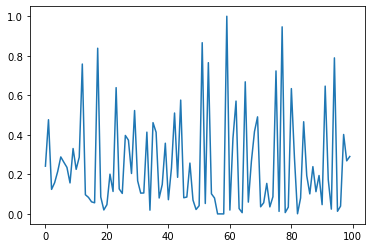

In [29]:
aml_model=AML_model(100,100,100,128,2,25,shared=False,attention=True,expand = False).to(device)
aml_model.load_state_dict(torch.load("./model_checkpoints_at/model_his.pt"))
plt.plot(aml_model(train_data["input"].to(device))[1].cpu().detach().numpy())

In [30]:
pred_1=[]
for idx,test_data in enumerate(test_encoded_loader):
    pred_1_q=aml_model(test_data["input"].to(device))[0].item()
    pred_1.append(pred_1_q)
#RUL

np.sum(np.ceil((abs(np.array(pred_1)-RUL))))#目测结果

3048.0

In [31]:
get_Accuracy(np.array(pred_1), RUL,lifetime_list)

matrix([[2.50000000e+01, 1.84611568e-02, 4.36987558e-03],
        [5.00000000e+01, 1.81462483e-02, 3.20464811e-03],
        [7.50000000e+01, 7.38610725e-02, 2.71269879e-02],
        [1.00000000e+02, 1.00147653e-01, 2.19831692e-02],
        [1.25000000e+02, 1.35216716e-01, 2.32905459e-02],
        [1.50000000e+02, 1.42687963e-01, 2.10044550e-02]])

# have cls

In [37]:
def fit_AML_model2(train_loader,path, num_head,RESUME=False,shared=False, attention=True, expand=False):
    model=AML_model2(100,100,100,128,2,num_head,shared=shared,attention=attention,expand = expand,
                    fix_mode_part=False).to(device)
    #model.load_state_dict(torch.load("./model_checkpoints_at/model_his_aml_cls.pt"))
    #model=AML_model(99,99,99).to(device)
    optimizer = getattr(torch.optim, CFG.optimizer)(filter(lambda p: p.requires_grad, model.parameters()), 
                                                    lr=CFG.lr,weight_decay=0.1)  # 优化器
    scheduler = getattr(torch.optim.lr_scheduler, CFG.scheduler)(optimizer, gamma=CFG.sc_Gamma)  # 指数型学习率
    start_epoch=-1
    if RESUME:
        path_checkpoint = path+'/ckpt_aml.pth'   # 断点路径
        checkpoint = torch.load(path_checkpoint)  # 加载断点

        model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数

        optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
        start_epoch = checkpoint['epoch']  # 设置开始的epoch
        scheduler.load_state_dict(checkpoint['scheduler'])


    for epoch in range(start_epoch+1,CFG.epoches):
        for data in train_loader:
            if attention:
                y_pred,cls_pred,weight_list=model(train_data["input"].to(device))
            else:
                y_pred,cls_pred=model(train_data["input"].to(device))
            y_pred=y_pred.unsqueeze(-1)
            y_target=train_data["RUL"].to(device).unsqueeze(-1).float()
            #y_target=train_data["RUL"].to(device).float()
            cls_target=train_data["mode"].to(device)
#             y_pred_=y_pred[torch.where(y_target>300)]
#             y_target_=y_target[torch.where(y_target>300)]
            loss=F.mse_loss(y_pred,y_target)+10*(-torch.sum(cls_pred*cls_target)/len(cls_pred)) #+\
                        #3 * F.mse_loss(y_pred_,y_target_)
        # loss = loss_function(pred_batch, target_batch, train_data, test_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        # scheduler.step(loss,last_loss)
        # last_loss = loss
        if CFG.print_training_process and epoch % 100 == 0:
            print(f"epoch:{epoch}, loss:{loss.item()},lr:{optimizer.state_dict()['param_groups'][0]['lr']}")
            checkpoint = {
                "net": model.state_dict(),
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                'scheduler': scheduler.state_dict()
            }
            if not os.path.isdir(path):
                os.mkdir(path)
            torch.save(checkpoint,
                       path+'/ckpt_aml.pth')
        if loss.mean() < CFG.jump_out_value:
            save_model_weights(model, "model_his_aml.pt",
                               cp_folder=path)
            break
        elif epoch == (CFG.epoches - 1):
            print(f"epoch:{epoch}, loss:{loss.item()}")
            save_model_weights(model, "model_his_aml.pt",
                               cp_folder=path)

In [68]:
set_seed(613)
fit_AML_model2(train_encoded_loader,"./model_checkpoints_at",num_head=10,RESUME=False,shared=False, 
               attention=True,expand=False)

epoch:0, loss:3587.646484375,lr:0.09910359161258742

 -> Saving weights to ./model_checkpoints_at\model_his_aml.pt



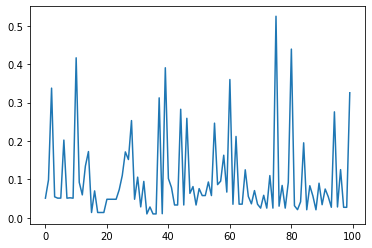

In [69]:
aml_model_2=AML_model2(100,100,100,128,2,10,shared=False, attention=True,expand=False).to(device)
aml_model_2.load_state_dict(torch.load("./model_checkpoints_at/model_his_aml.pt"))
plt.plot(aml_model_2(train_data["input"].to(device))[2][1].cpu().detach().numpy())

In [70]:
pred_2=[]
for idx,test_data in enumerate(test_encoded_loader):
    pred_2_q=aml_model_2(test_data["input"].to(device))[0].item()
    pred_2.append(pred_2_q)
#RUL
np.sum(np.ceil((abs(np.array(pred_2)-RUL))))#目测结果

1961.0

In [71]:
get_Accuracy(np.array(pred_2), RUL,lifetime_list)

matrix([[2.50000000e+01, 2.63942218e-02, 6.03366134e-03],
        [5.00000000e+01, 2.56681571e-02, 4.03137053e-03],
        [7.50000000e+01, 3.75142212e-02, 6.67039949e-03],
        [1.00000000e+02, 6.08335536e-02, 1.14921346e-02],
        [1.25000000e+02, 8.24033737e-02, 1.23825246e-02],
        [1.50000000e+02, 9.05451079e-02, 1.14454474e-02]])

# 特征增强

In [103]:
def feature_enhance(instance_train,instance_test):
    #instance_test_enhanced = instance_test
    feature_enhanced_list=[]
    for test_idx in tqdm(range(len(instance_test))):
        distance_list=torch.zeros(len(instance_train))
        y = instance_test[test_idx]["input"]
        for train_idx in range(len(instance_train)):
            x = instance_train[train_idx]["input"]
            distance = F.pairwise_distance(x, y, p=2)
            distance_list[train_idx] = 1/distance
        #diag=torch.exp(distance_list).unsqueeze(-1) 
        diag=distance_list.unsqueeze(-1)
#         diag[torch.where(diag < torch.quantile(diag, 0.5, dim=0,
#                                             keepdim=False,
#                                            interpolation='nearest'))] = 0
        diag_reg=diag / torch.sum(diag)
        if instance_test[test_idx]["lifetime"]<110:
            feature_enhanced_list.append(torch.sum(instance_train.all_feature_list*diag_reg,dim=0))
        else:
            feature_enhanced_list.append(y)
    return feature_enhanced_list    # 

In [104]:
feature_enhanced_list = feature_enhance(train_dataset_expend_encoded,test_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

In [105]:
test_dataset_enhanced = AircraftDataset_no_expend_feature_extraction(df_test, 
                                                            test_label, 
                                                            feature_enhanced_list)
test_encoded_enhanced_loader = DataLoader(
    test_dataset_enhanced,
    batch_size=1,
    shuffle=False)

In [106]:
pred_3=[]
for idx,test_data in enumerate(test_encoded_enhanced_loader):
    pred_3_q=aml_model_2(test_data["input"].to(device))[0].item()
    pred_3.append(pred_3_q)
#RUL
np.sum(np.ceil((abs(np.array(pred_3)-RUL))))#目测结果

1360.0

In [107]:
get_Accuracy(np.array(pred_3), RUL,lifetime_list)

matrix([[2.50000000e+01, 2.63942218e-02, 6.03366134e-03],
        [5.00000000e+01, 2.56681571e-02, 4.03137053e-03],
        [7.50000000e+01, 3.94564761e-02, 7.13177701e-03],
        [1.00000000e+02, 5.30839100e-02, 7.67805092e-03],
        [1.25000000e+02, 6.02137841e-02, 6.56986527e-03],
        [1.50000000e+02, 5.98732851e-02, 5.79522163e-03]])